In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

from skimage import io

from scipy.special import logsumexp
from sklearn.cluster import KMeans

import PIL.Image
import IPython.display

from aml_utils import test_case_checker, perform_computation

# *Assignment Summary

**Image segmentation using EM**: You can segment an image using a clustering method - each segment is the cluster center to which a pixel belongs. In this exercise, you will represent an image pixel by its r, g, and b values (so use color images!). Apply the EM algorithm to the mixture of normal distributions model (also called Gaussian Mixture Model or GMM) to cluster image pixels, then segment the image by mapping each pixel to the cluster center with the highest value of the posterior probability for that pixel. Rather than using a package, you will implement the EM algorithm yourself. You will display results for the three included images, although you can use any color image you want.

* Segment each of the test images to 10, 20, and 50 segments. You should display these segmented images as images, where each pixel's color is replaced with the mean color of the closest segment.

* We will identify one special test image. You should segment this to 20 segments using five different start points, and display the result for each case. Is there much variation in the result? The test image is the sunset image

# *EM for Mixture of Normals in Matrix Form

For you convenience, we bring the reading assignment file here so that you can use it.

<font color='red'> **Caution** </font> Depending on your browser, you might need to right click on this pdf document to see the display options.

In [4]:
from IPython.display import IFrame
IFrame("../EMSegmentation-lib/EMSegmentation.pdf", width=1000, height=800)    

# 1. Implementing the Gaussian Mixture Model

## 1.1 The Expectation Step

# <span style="color:blue">Task 1</span>

Write a function `find_H` that calculates the 

$$H_{i,j} := -\frac{1}{2} \bigg[ (\mathbf{x}_i-\mathbf{\mu}_j)^T(\mathbf{x}_i-\mathbf{\mu}_j) \bigg]$$

matrix, and takes the following arguments as input:

1. `X`: A numpy array of the shape `(N,d)` where `N` is the number of pixels in the image (i.e., number of data points in this problem) and `d` is the number of fundamental pixel colors (i.e., dimension of the data space in this problem). 
  * Do not assume anything about `N` or `d` other than being positive integers.
  * Do not assume anything about `X`'s range of values or data type. 
  
  `X` is equivalent to the data matrix $X$ in the review document above.

2. `mu`: A numpy array of the shape `(K,d)` where `K` is the target number of clusters for clustering and `d` is the number of colors (i.e., dimension of the data space in this problem). Again, do not assume anything about `K` other than being a positive integer. This variable is equivalent to the means matrix $\mu$ in the review document above.

Your function should return the numpy array `H` with the shape of `(N, K)` and `np.float64` data type.

**Important Note**: Try and avoid using loops for constructing this pairwise distance matrix. You can find detailed explanation on how to efficiently compute $H$ in the document above.

In [5]:
def find_H(X, mu):
    N = X.shape[0]
    K = mu.shape[0]
    assert X.shape[1] == mu.shape[1]
    
    # your code here
    H1 = np.repeat(np.sum(X**2, axis=1).reshape(-1,1), K, axis=1)
    H2 = np.repeat(np.sum(mu**2, axis=1).reshape(-1,1).T, N, axis=0) # reshape is necessary to convert 1D array to a 2D matrix
    H3 = X @ mu.T
    
    H = -1/2 * (H1 + H2 - 2*H3)
    
    assert H.shape == (N,K)
    assert H.dtype == np.float64
    return H

In [6]:
# Performing sanity checks on your implementation
some_X = np.array([[ 0,  1, 12,  3,  4],
                   [ 5, 16,  7,  8,  9],
                   [ 0, 11, 12, 13,  4],
                   [15, 16, 17,  8, 19],
                   [ 0,  1, 12,  3,  4],
                   [ 5, 16,  7,  8, 13],
                   [ 4, 15,  0,  5,  0]])

some_mu = np.array([[ 0,  1, 18, 15,  5],
                    [13,  9, 23,  3, 22],
                    [ 2, 10, 17,  4,  8]])

assert np.array_equal(find_H(some_X, some_mu), np.array([[ -90.5, -339. ,  -63.5],
                                                         [-218. , -281.5,  -81. ],
                                                         [ -70.5, -359. ,  -63.5],
                                                         [-348. ,  -61.5, -171. ],
                                                         [ -90.5, -339. ,  -63.5],
                                                         [-242. , -237.5,  -93. ],
                                                         [-330.5, -567. , -191.5]]))

# Checking against the pre-computed test database
test_results = test_case_checker(find_H, task_id=1)
assert test_results['passed'], test_results['message']

In [7]:
# This cell is left empty as a seperator. You can leave this cell as it is, and you should not delete it.


# <span style="color:blue">Task 2</span>

Write a function `find_logW` that calculates the $\log W_{i,j}$ matrix, and takes the following arguments as input:

1. `H`: A numpy array of the shape `(N,K)` where `N` is the number of pixels in the image and `K` is the number of clusters. This is the supposed output of the `find_H` function you wrote, and is equivalent to the matrix $H$ in the review document above.
  * Do not assume anything about `N` or `K` other than being positive integers. 
2. `log_pi`: A numpy array of the shape `(K,1)` where `K` is the number of clusters. This variable is equivalent to the element-wise natural log of the prior probabilities vector $\pi$ in the review document above.

Your function should return the numpy array `logW` with the shape of `(N, K)` whose $i^{th}$ row and $j^{th}$ column should be

$$\log W_{i,j} := \log\bigg(\frac{\pi_j \exp\bigg(-\frac{1}{2} \bigg[ (\mathbf{x}_i-\mathbf{\mu}_j)^T(\mathbf{x}_i-\mathbf{\mu}_j) \bigg]\bigg)}{\sum_{l=1}^{K} \pi_l \exp\bigg(-\frac{1}{2} \bigg[ (\mathbf{x}_i-\mathbf{\mu}_l)^T(\mathbf{x}_i-\mathbf{\mu}_l) \bigg]\bigg)}\bigg)$$

**Important Note**: You **should** use the `logsumexp` function imported above from scipy's library to make sure that numerical stability would not be a problem. In other words, don't try and exponentiate the vector `log_pi` to obtain the $\pi$ vector; this will result in numerical instability. 

In [8]:
def find_logW(H, log_pi):
    N, K = H.shape
    
    # your code here
    logE = H + np.repeat(log_pi.T, N, axis=0) # NxK
    logF = np.repeat(logsumexp(logE, axis=1).reshape(-1,1), K, axis=1) 
    logW = logE - logF
    
    assert logW.shape == (N,K)
    assert not np.isnan(logW).any()
    assert not np.isinf(logW).any()
    return logW

In [9]:
# Performing sanity checks on your implementation
some_X = np.array([[ 0,  1, 12,  3,  4],
                   [ 5, 16,  7,  8,  9],
                   [ 0, 11, 12, 13,  4],
                   [15, 16, 17,  8, 19],
                   [ 0,  1, 12,  3,  4],
                   [ 5, 16,  7,  8, 13],
                   [ 4, 15,  0,  5,  0]])

some_mu = np.array([[ 0,  1, 18, 15,  5],
                    [13,  9, 23,  3, 22],
                    [ 2, 10, 17,  4,  8]])

some_H = np.array([[ -90.5, -339. ,  -63.5],
                   [-218. , -281.5,  -81. ],
                   [ -70.5, -359. ,  -63.5],
                   [-348. ,  -61.5, -171. ],
                   [ -90.5, -339. ,  -63.5],
                   [-242. , -237.5,  -93. ],
                   [-330.5, -567. , -191.5]])

some_log_pi = np.log(some_mu.sum(axis=1)/some_mu.sum()).reshape(-1,1)

some_logW = find_logW(some_H, some_log_pi)

assert np.allclose(some_logW.round(2), np.array([[ -27.05, -274.97,   -0.  ],
                                                 [-137.05, -199.97,    0.  ],
                                                 [  -7.05, -294.97,   -0.  ],
                                                 [-287.08,    0.  , -110.03],
                                                 [ -27.05, -274.97,   -0.  ],
                                                 [-149.05, -143.97,    0.  ],
                                                 [-139.05, -374.97,    0.  ]]))

# Checking against the pre-computed test database
test_results = test_case_checker(find_logW, task_id=2)
assert test_results['passed'], test_results['message']

In [10]:
# This cell is left empty as a seperator. You can leave this cell as it is, and you should not delete it.


## 1.2 The Maximization Step

# <span style="color:blue">Task 3</span>

Write a function `update_logpi` that computes the $\log \pi^{\text{new}}$ vector, and takes the following argument as input:

1. `logW`: A numpy array of the shape `(N,K)` where `N` is the number of pixels in the image and `K` is the number of clusters. This is the supposed output of the `find_logW` function you wrote, and is equivalent to the matrix $\log W$ in the review document above.
  * Do not assume anything about `N` or `K` other than being positive integers. 

Your function should return the numpy array `log_pi` with the shape of `(K, 1)` whose $j^{th}$ element should be

$$\log \pi^{\text{new}}_{j} := \log \frac{\sum_{i=1}^N W_{i,j}}{N}$$

**Important Note**: You **should** use the `logsumexp` function imported above from scipy's library to make sure that numerical stability would not be a problem. In other words, don't try and exponentiate the matrix `logW` to obtain the $W$ matrix; this will result in numerical instability. 

**Important Note**: Try and avoid using loops for constructing this posterior. You can find detailed explanation on how to efficiently compute $\log \pi^{\text{new}}$ in the document above.

In [17]:
def update_logpi(logW):
    N,K = logW.shape
    
    # your code here
    log_pi = logsumexp(logW.T, axis=1).reshape(-1,1) - np.log(N)
    
    assert log_pi.shape == (K,1)
    assert not np.isnan(log_pi).any()
    assert not np.isinf(log_pi).any()
    
    return log_pi

In [18]:
# Performing sanity checks on your implementation
some_logW = np.array([[ -27.05, -274.97,   -0.  ],
                      [-137.05, -199.97,    0.  ],
                      [  -7.05, -294.97,   -0.  ],
                      [-287.08,    0.  , -110.03],
                      [ -27.05, -274.97,   -0.  ],
                      [-149.05, -143.97,    0.  ],
                      [-139.05, -374.97,    0.  ]])

some_logpi_new = update_logpi(some_logW)

assert np.array_equal(some_logpi_new.round(2), np.array([[-9.  ],
                                                         [-1.95],
                                                         [-0.15]]))

# Checking against the pre-computed test database
test_results = test_case_checker(update_logpi, task_id=3)
assert test_results['passed'], test_results['message']

In [19]:
# This cell is left empty as a seperator. You can leave this cell as it is, and you should not delete it.


# <span style="color:blue">Task 4</span>

Write a function `update_mu` that computes the $\mu^{\text{new}}$ matrix, and takes the following arguments as input:

1. `X`: A numpy array of the shape `(N,d)` where `N` is the number of pixels in the image (i.e., number of data points in this problem) and `d` is the number of fundamental pixel colors (i.e., dimension of the data space in this problem). 
  * Do not assume anything about `N` or `d` other than being positive integers.
  * Do not assume anything about `X`'s range of values or data type. 
  
  `X` is equivalent to the data matrix $X$ in the review document above.
2. `logW`: A numpy array of the shape `(N,K)` where `N` is the number of documents and `K` is the number of clusters. This is the supposed output of the `find_logW` function you wrote, and is equivalent to the matrix $\log W$ in the review document above.
  * Do not assume anything about `K` other than being a positive integer. 

Your function should return the numpy array `mu` with the shape of `(K, d)` whose $j^{th}$ centroid should be

$$\mathbf{\mu}_j^{new} = \frac{\sum_{i=1}^N \mathbf{x_i} W_{i,j}}{\sum_{i=1}^N W_{i,j}}$$

**Important Note**: Try and avoid using loops for constructing this posterior. You can find detailed explanation on how to efficiently compute $\mu^{\text{new}}$ in the document above.

In [29]:
def update_mu(X, logW):
    N,K = logW.shape
    d = X.shape[1]
    assert X.shape[0] == N
    
    # your code here
    R = np.exp(logW.T)
    mu = (R @ X) / np.repeat(np.sum(np.exp(logW.T), axis=1).reshape(-1,1), d, axis=1) # Kxd
    
    assert mu.shape == (K,d)
    assert not np.isnan(mu).any()
    assert not np.isinf(mu).any()
    return mu

In [30]:
# Performing sanity checks on your implementation
some_X = np.array([[ 0,  1, 12,  3,  4],
                   [ 5, 16,  7,  8,  9],
                   [ 0, 11, 12, 13,  4],
                   [15, 16, 17,  8, 19],
                   [ 0,  1, 12,  3,  4],
                   [ 5, 16,  7,  8, 13],
                   [ 4, 15,  0,  5,  0]])

some_logW = np.array([[ -27.05, -274.97,   -0.  ],
                      [-137.05, -199.97,    0.  ],
                      [  -7.05, -294.97,   -0.  ],
                      [-287.08,    0.  , -110.03],
                      [ -27.05, -274.97,   -0.  ],
                      [-149.05, -143.97,    0.  ],
                      [-139.05, -374.97,    0.  ]])

some_mu_new = update_mu(some_X, some_logW)

assert np.array_equal(some_mu_new.round(3), np.array([[ 0.   , 11.   , 12.   , 13.   ,  4.   ],
                                                      [15.   , 16.   , 17.   ,  8.   , 19.   ],
                                                      [ 2.333, 10.   ,  8.333,  6.667,  5.667]]))

# Checking against the pre-computed test database
test_results = test_case_checker(update_mu, task_id=4)
assert test_results['passed'], test_results['message']

In [31]:
# This cell is left empty as a seperator. You can leave this cell as it is, and you should not delete it.


## 1.3 Writing the full Expectation-Maximization Iteration

In [32]:
def GMM(X, K, initialization_method='kmeans', iterations=100, seed=12345):
    N, d = X.shape
    pi_init = np.ones((K,1))/float(K)
    
    np_random = np.random.RandomState(seed=seed)
    if initialization_method == 'random_pixels':
        mu_init = X[np_random.choice(N, K), :] # mu.shape = (K, d)
    elif initialization_method == 'kmeans':
        kmeans = KMeans(n_clusters=K, random_state=np_random).fit(X)
        mu_init = kmeans.cluster_centers_  # mu.shape = (K, d)

    log_pi = np.log(pi_init) #log_pi.shape = (K,1)
    mu = mu_init

    for iteration in range(iterations):
        print('.', end='')
        #The E-Step
        H = find_H(X, mu)
        logW = find_logW(H, log_pi)

        #The M-Step
        log_pi = update_logpi(logW)
        mu = update_mu(X, logW)
    print('', end=' ')
    
    return mu, H, log_pi

In [33]:
def segment(raw_image, K, initialization_method ='random_pixels', seed=12345):
    mu, H, log_pi = GMM(X=raw_image.reshape(-1, 3), K=K, 
                        initialization_method=initialization_method, 
                        iterations=10, seed=seed)
    reconst_image = mu[H.argmax(axis=1), :].reshape(*raw_image.shape)

    fig, axes = plt.subplots(1,2, figsize=(8,4), dpi=144)

    ax = axes[0]
    ax.imshow(raw_image)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title('Original Image')

    ax = axes[1]
    ax.imshow(reconst_image.astype(np.uint8))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'Segmented Image (K={K})')

    fig.tight_layout()

# 2. Image Segmentation

## 2.1 The Sunset Image

.......... .......... .......... 

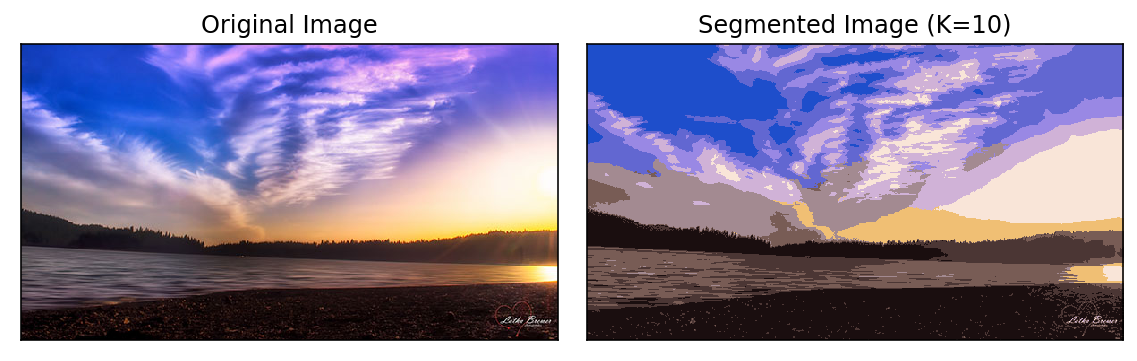

In [ ]:
if perform_computation:
    raw_image = io.imread('../EMSegmentation-lib/pics/smallsunset.jpg')
    segment(raw_image, 10, initialization_method = 'kmeans')
    segment(raw_image, 20, initialization_method = 'kmeans')
    segment(raw_image, 50, initialization_method = 'kmeans')

## 2.2 The Flower Image

.......... .......... .......... 

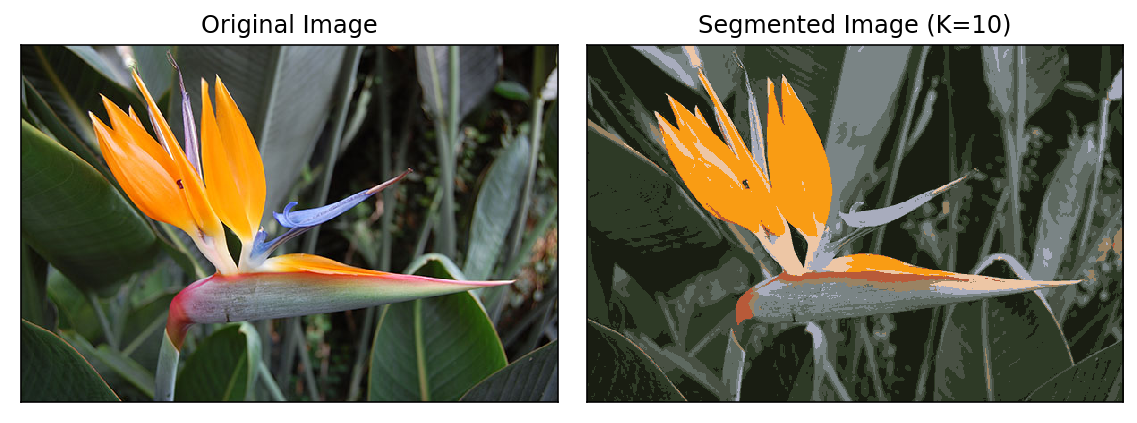

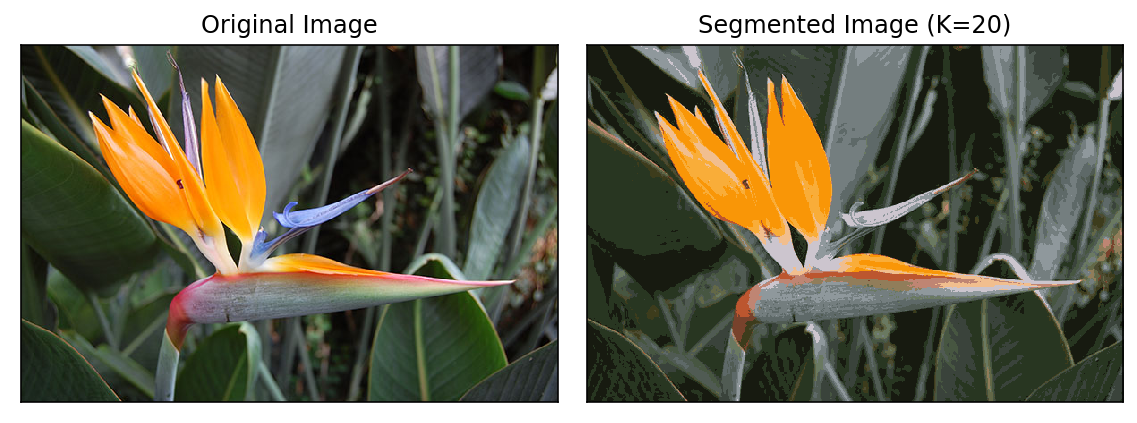

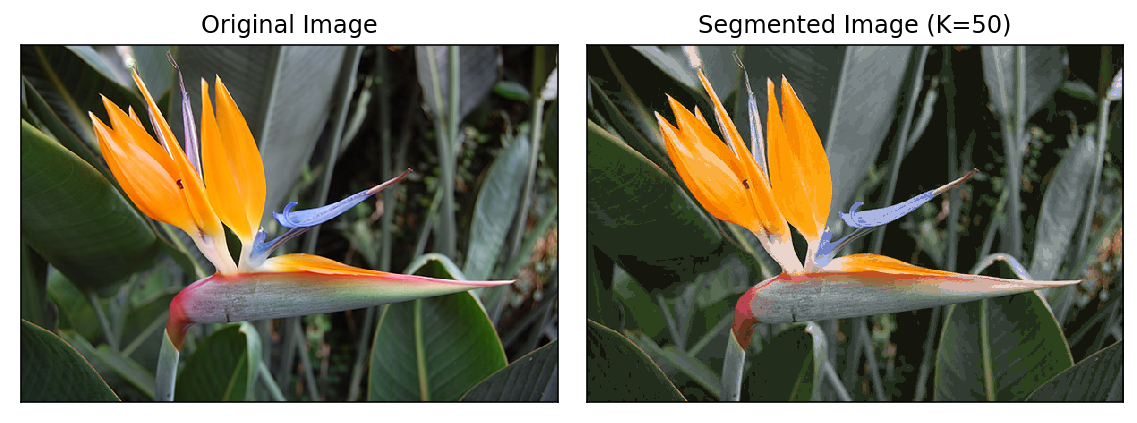

In [35]:
if perform_computation:
    raw_image = io.imread('../EMSegmentation-lib/pics/smallstrelitzia.jpg')
    segment(raw_image, 10)
    segment(raw_image, 20)
    segment(raw_image, 50)

## 2.3 The Fish Image

.......... .......... .......... 

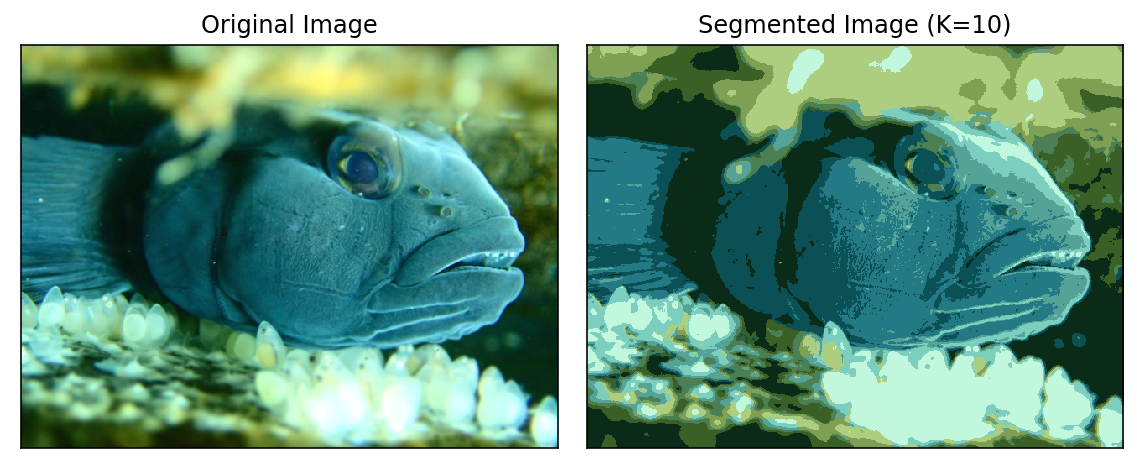

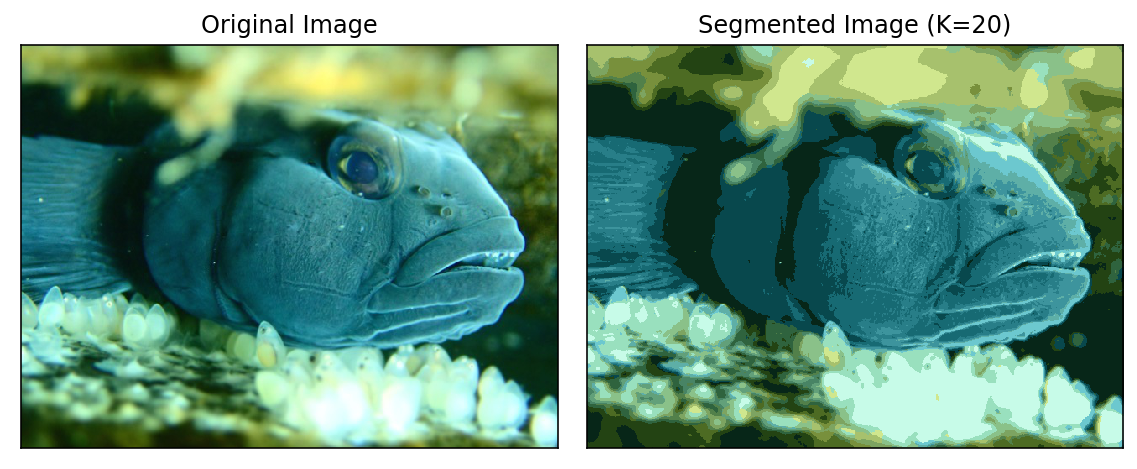

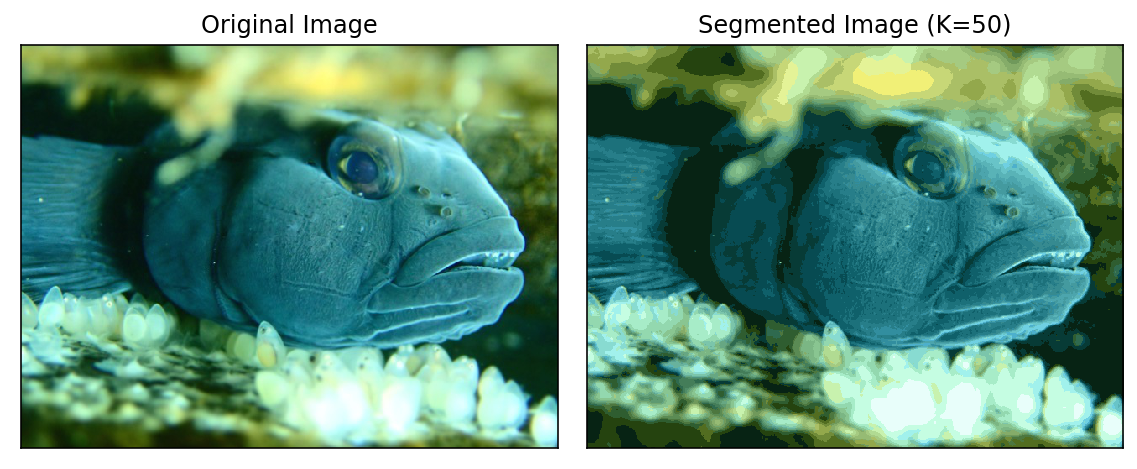

In [36]:
if perform_computation:
    raw_image = io.imread('../EMSegmentation-lib/pics/RobertMixed03.jpg')
    segment(raw_image, 10)
    segment(raw_image, 20)
    segment(raw_image, 50)